<a href="https://colab.research.google.com/github/1ucky40nc3/stylegan3-super-recognizer/blob/main/classify_faces_stylegan3_super_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title 👉 Check if a GPU is connected to the runtime ❓ 💪
!nvidia-smi

Wed Nov 17 16:43:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# @title 👉 Set up an environment (ONLY RUN ONCE ❗)
%cd /content

!git clone https://github.com/NVlabs/stylegan3.git
!pip install ninja

%cd stylegan3/

downloaded_models = {}

/content
fatal: destination path 'stylegan3' already exists and is not an empty directory.
/content/stylegan3


In [ ]:
# @title 👉 Download a StyleGAN3 model 🤖💻

import os


model = "stylegan3-t-ffhq-1024x1024.pkl" # @param ["stylegan3-t-ffhq-1024x1024.pkl", "tylegan3-t-ffhqu-1024x1024.pkl", "stylegan3-t-ffhqu-256x256.pkl", "stylegan3-r-ffhq-1024x1024.pkl", "stylegan3-r-ffhqu-1024x1024.pkl", "stylegan3-r-ffhqu-256x256.pkl", "stylegan3-t-metfaces-1024x1024.pkl", "stylegan3-t-metfacesu-1024x1024.pkl", "stylegan3-r-metfaces-1024x1024.pkl", "stylegan3-r-metfacesu-1024x1024.pkl", "stylegan3-t-afhqv2-512x512.pkl"]

if model not in downloaded_models:
    # Create the url to the resource.
    url = f"https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/{model}"
    print("[INFO] Downloading the model from NVIDIA.")

    # Download the pretrained model. 
    !wget $url

    # Mark the model as downloaded.
    downloaded_models[model] = url
else:
    print("[INFO] The model has already been downloaded.")

stylegan3_path = os.path.join(os.getcwd(), model)

[INFO] Downloading the model from NVIDIA.
--2021-11-17 16:43:19--  https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-t-ffhq-1024x1024.pkl
Resolving api.ngc.nvidia.com (api.ngc.nvidia.com)... 54.193.0.205, 54.219.145.142
Connecting to api.ngc.nvidia.com (api.ngc.nvidia.com)|54.193.0.205|:443... connected.
HTTP request sent, awaiting response... 302 
Location: https://prod-model-registry-ngc-bucket.s3.us-west-2.amazonaws.com/org/nvidia/team/research/models/stylegan3/versions/1/files/stylegan3-t-ffhq-1024x1024.pkl?response-content-disposition=attachment%3B%20filename%3D%22stylegan3-t-ffhq-1024x1024.pkl%22&response-content-type=application%2Foctet-stream&X-Amz-Security-Token=IQoJb3JpZ2luX2VjEPD%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaCXVzLXdlc3QtMSJHMEUCIQDeaS7p0Mjt%2BeE1c720DIdwmKd2wkU%2FxQBt1s%2B76SHMFQIgExv%2FgwRbOBbokM6lwGrWm5mEVt4q%2FRuNt04R4Ir2BsAqgwQIqf%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FARADGgw3ODkzNjMxMzUwMjciDJFGrpboh%2BLqCrm38irXAw40VQ1uRln3etorCZNycimq

In [ ]:
# @title 👉 Set up the code to generate faces 📰💻
from typing import Tuple
from typing import Optional

import cv2
import torch
import base64
import random
import numpy as np
import torchvision
from tqdm import tqdm
from PIL import Image
from IPython.display import HTML
import torchvision.transforms as T
from IPython.display import display
from numpy.random import RandomState
from torchvision.transforms import functional as F

from dnnlib.util import open_url
from gen_video import layout_grid
from legacy import load_network_pkl
from gen_images import make_transform


device = torch.device('cuda')


def stylegan3_inference(
        model: str,
        z: torch.Tensor,
        translate: Tuple[float, float]=(0., 0.),
        rotate: float=0.,
        truncation_psi: float=1.,
        noise_mode: str='const'
    ) -> torch.Tensor:
    """Run inference with a StyleGAN3 model."""
    if not translate == (0., 0.) or not rotate == 0.:
        matrix = make_transform(translate, rotate)
        matrix = np.linalg.inv(matrix)
        matrix = torch.from_numpy(matrix)

        model.synthesis.input.transform.copy_(matrix)

    # Set class labels in the case for conditional networks.
    label = torch.zeros(1, model.c_dim, device=device)

    return model(z, label, 
                 truncation_psi=truncation_psi, 
                 noise_mode=noise_mode)


def generate_num(
        url: str,
        num: int=12,
        sigma: float=0.6,
        seed: int=2,
        translate: Tuple[float, float]=(0., 0.),
        rotate: float=0.,
        class_idx: Optional[int]=None,
        truncation_psi: float=1.,
        noise_mode: str='const'
    ) -> torch.Tensor:
    # Note: The first inference run may take longer because of plugins beeing set up.

    with open_url(url) as pkl:
        model = load_network_pkl(pkl)["G_ema"]
        model = model.to(device)
    
    out = []
    for i in tqdm(range(num)):
        # Generate the image seed.
        z = RandomState(seed).randn(1, model.z_dim)
        z = torch.from_numpy(z).to(device)

        p = (torch.rand_like(z)*2 - 1)*sigma
        z += p

        y = stylegan3_inference(model, z).cpu()
        out.append(y)

    return out


def transform(img: torch.Tensor) -> torch.Tensor:
    # reshape from (batch, channels, height, width) to (batch, height, width, channels)
    img = img.permute(0, 2, 3, 1)
    
    # normalize the image from approximately [-1, 1] to [0, 255]
    img = img*127.5 + 128
    img = img.clamp(0, 255)

    return img.to(torch.uint8)

def save(img: np.ndarray, filename: str="img.png"):
    Image.fromarray(img, 'RGB').save(filename)

def image_data_url(filename: str) -> str:
    image = open(filename,'rb').read()
    image = base64.b64encode(image).decode()

    return "data:image/jpeg;base64," + image


def show_img(
        img: np.ndarray, 
        filename: str="img.png",
        width: int=800
    ):
    save(img, filename)

    html = f"""
    <img src="{image_data_url(filename)}" width="{width}"></img>
    """

    display(HTML(html))

[Step | 1/5] 	Generating the original...


100%|██████████| 1/1 [00:00<00:00,  7.43it/s]


[Step | 2/5] 	Generating the clone...


100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


[Step | 3/5] 	Generating the other faces...


100%|██████████| 5/5 [00:00<00:00,  8.12it/s]


[Step | 4/5] 	Postprocessing of the generated images...
[Step | 5/5] 	Preparing images for display...



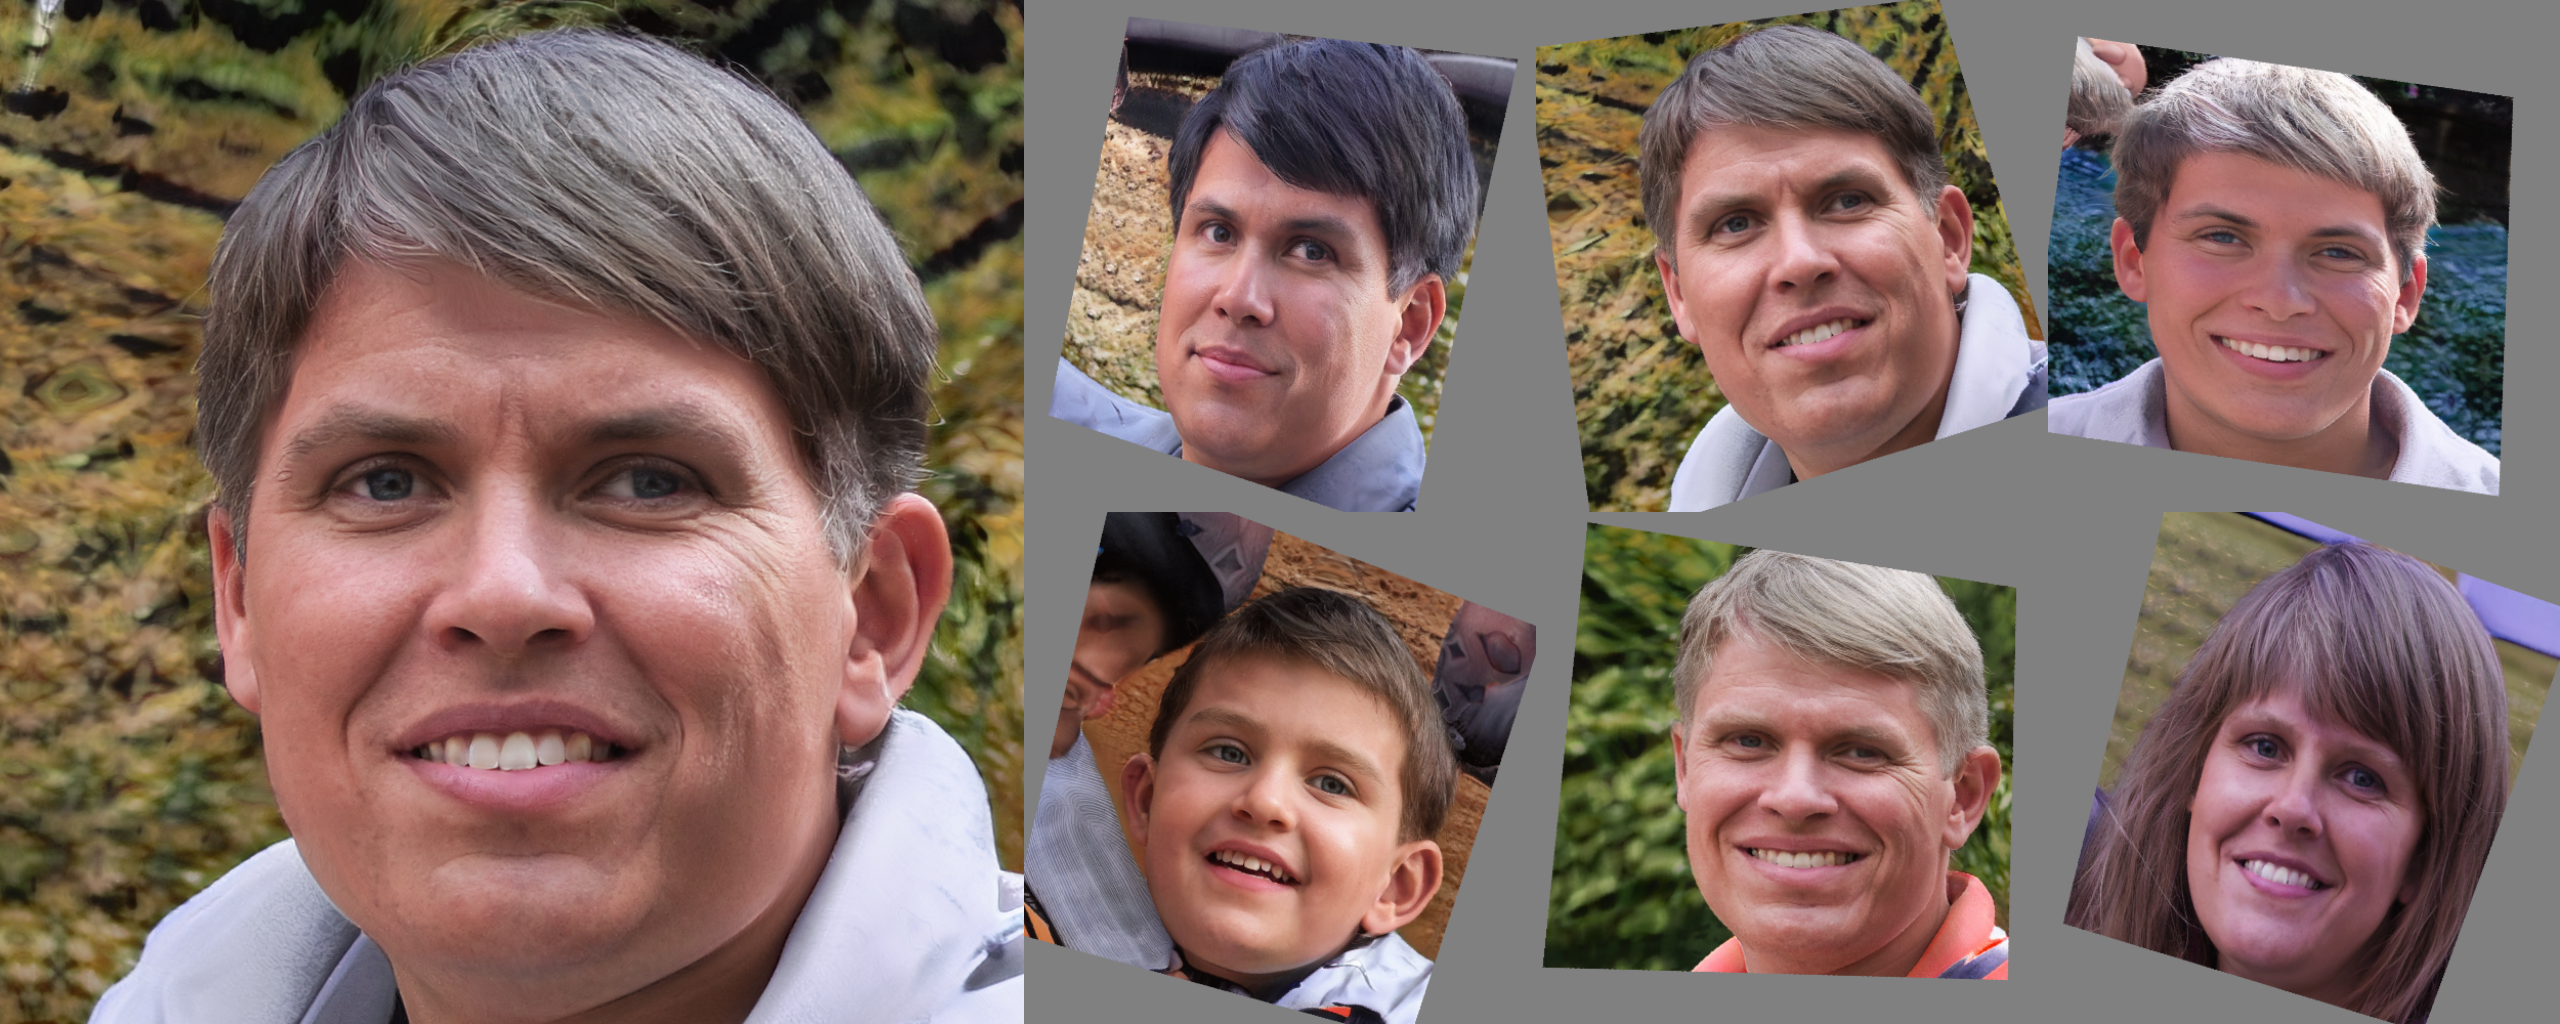

In [20]:
# @title 👍 Generate the faces with the given parameters 🤖🤯

distortion = 0.3 #@param {type:"slider", min: 0.01, max: 1.0, step: 0.01}
#@markdown * Control how distorted the images are. **[higher==harder]**
rotation = 20 #@param {type:"slider", min: 0, max: 360, step: 10}
#@markdown * Control the images rotation are. *(Rotation in degrees)*
img_size =  500 #@param {type:"slider", min: 100, max: 1024, step: 10}
number_imgs = 6 #@param [6, 9, 12, 15, 16] {type:"raw"}
#@markdown * Control the number of generated images.
clone_sigma = 0.16 #@param {type:"slider", min: 0.01, max: 1.0, step: 0.01}
#@markdown * Control how related the original and cloned images are. **[higher==harder]**
other_sigma = 1. #@param {type:"slider", min: 0.01, max: 1.0, step: 0.01}
#@markdown * Control how related the rest of the faces are. **[lower==harder]**

#@markdown ---

orient_images_horizontal = True #@param {type:"boolean"}

challenge_compose = T.Compose([
    T.RandomPerspective(
        distortion_scale=distortion, p=1.),
    T.RandomRotation(rotation),
    T.Resize((img_size,)*2)
])

def process(img: torch.Tensor) -> torch.Tensor:
    return challenge_compose(img[0])

grid_shape = {
    6: (3, 2),
    9: (3, 3),
    12: (4, 3),
    15: (5, 3),
    16: (4, 4)
}

seed = random.randint(0, 10**6)
print("[Step | 1/5] \tGenerating the original...")
original = generate_num(
    stylegan3_path, 
    num=1, seed=seed, 
    sigma=0.)
print("[Step | 2/5] \tGenerating the clone...")
clone = generate_num(
    stylegan3_path, 
    num=1, seed=seed, 
    sigma=clone_sigma)
print("[Step | 3/5] \tGenerating the other faces...")
others = generate_num(
    stylegan3_path, 
    num=number_imgs - 1, 
    seed=seed,
    sigma=other_sigma)

imgs = [*clone, *others]

idxs = list(range(len(imgs)))
random.shuffle(idxs)

print("[Step | 4/5] \tPostprocessing of the generated images...")
original = layout_grid(original[0], *(1, 1))
processed = [process(imgs[i]) for i in idxs]
challenge = torch.stack(processed)
challenge = layout_grid(
    challenge, *grid_shape[number_imgs])


print("[Step | 5/5] \tPreparing images for display...")
if orient_images_horizontal:
    oheight, owidth, _ = original.shape
    cheight, cwidth, _ = challenge.shape

    height = max(oheight, cheight)

    oscale = height/oheight
    cscale = height/cheight


    roriginal = cv2.resize(original, (int(owidth*oscale), height))
    rchallenge = cv2.resize(challenge, (int(cwidth*cscale), height))

    combined = np.concatenate((roriginal, rchallenge), 1)
    show_img(combined)
else:
    show_img(original, width=500)
    show_img(challenge, width=500)


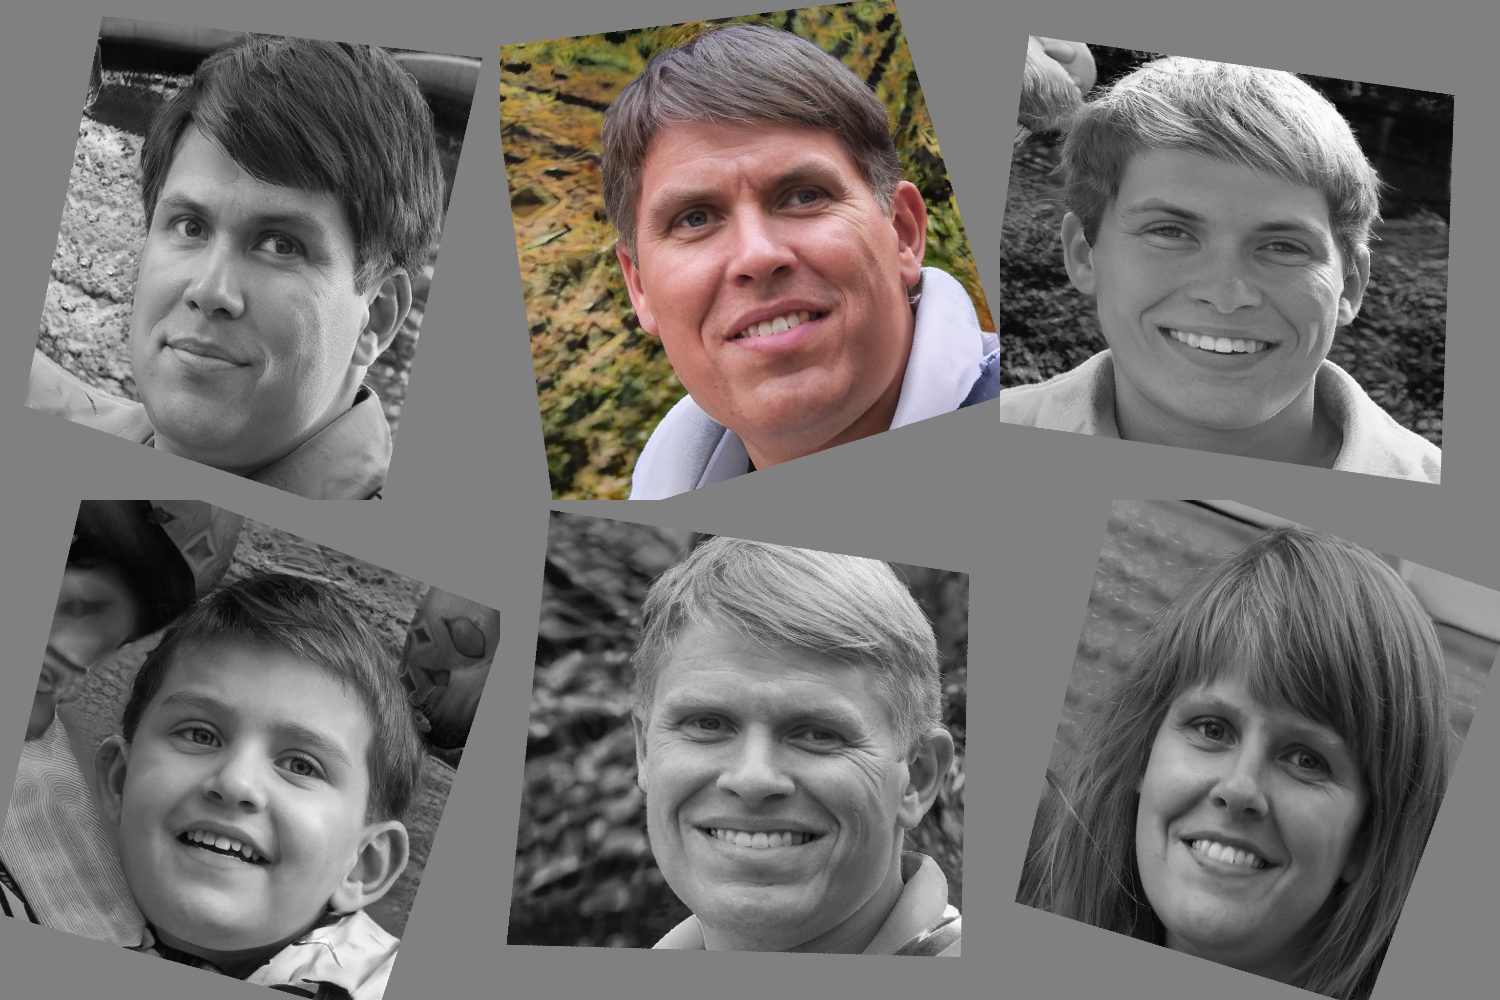

In [21]:
# @title 🌟 Reveal the intented result 🤯❓

reveal_compose = T.Compose([
    T.Grayscale(3)
])

reveal = []
for i, img in enumerate(processed):
    if i == idxs.index(0):
        reveal.append(img)
    else:
        reveal.append(
            reveal_compose(img))
    
reveal = torch.stack(reveal)
reveal = layout_grid(
    reveal, *grid_shape[number_imgs])

show_img(reveal, width=500)